**Packages**

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sn

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import tensorflow_addons as tfa
import tifffile

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelBinarizer, normalize


import os

import scipy

2023-03-26 16:09:23.423141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-26 16:09:24.398915: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/amazon/efa/lib:/opt/amazon/openmpi/lib:/usr/local/cuda/efa/lib:/usr/local/cuda/lib:/usr/local/cuda:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/targets/x86_64-linux/lib:/usr/local/lib:/usr/lib:/opt/amazon/efa/lib:/opt/amazon/openmpi/lib:/usr/local/cuda/efa/lib:/usr/local/cuda/lib:/usr/local/cuda:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cud

**Helper Functions**

In [2]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['loss']),
                max(history.history['val_loss'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)

In [3]:
def plot_accuracy(history):
   # plt.plot(history.history['loss'], label='loss')
   # plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['accuracy']),
                max(history.history['val_accuracy'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)

In [4]:
def plot_f1(history):
    plt.plot(history.history['f1'], label='train_f1')
    plt.plot(history.history['val_f1'], label='val_f1')
    plt.ylim([0, 
            max(
                max(history.history['f1']),
                max(history.history['val_f1'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 Score')
    plt.legend()
    plt.grid(True)

In [5]:
# FROM https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py

kaiming_normal = keras.initializers.VarianceScaling(scale=2.0, mode='fan_out', distribution='untruncated_normal')

def conv3x3(x, out_planes, stride=1, name=None):
    x = layers.ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    return layers.Conv2D(filters=out_planes, kernel_size=3, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=name)(x)

def basic_block(x, planes, stride=1, downsample=None, name=None):
    identity = x

    out = conv3x3(x, planes, stride=stride, name=f'{name}.conv1')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn1')(out)
    out = layers.ReLU(name=f'{name}.relu1')(out)

    out = conv3x3(out, planes, name=f'{name}.conv2')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn2')(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = layers.Add(name=f'{name}.add')([identity, out])
    out = layers.ReLU(name=f'{name}.relu2')(out)

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    if stride != 1 or inplanes != planes:
        downsample = [
            layers.Conv2D(filters=planes, kernel_size=1, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=f'{name}.0.downsample.0'),
            layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.0.downsample.1'),
        ]

    x = basic_block(x, planes, stride, downsample, name=f'{name}.0')
    for i in range(1, blocks):
        x = basic_block(x, planes, name=f'{name}.{i}')

    return x

def resnet(x, blocks_per_layer, num_classes=1000):
    x = layers.ZeroPadding2D(padding=3, name='conv1_pad')(x)
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, kernel_initializer=kaiming_normal, name='conv1')(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)
    x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

    x1 = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    x2 = make_layer(x1, 128, blocks_per_layer[1], stride=2, name='layer2')
    x3 = make_layer(x2, 256, blocks_per_layer[2], stride=2, name='layer3')
    x4 = make_layer(x3, 512, blocks_per_layer[3], stride=2, name='layer4')

    x = layers.GlobalAveragePooling2D(name='avgpool')(x4)
    initializer = keras.initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512))
    x = layers.Dense(units=num_classes, kernel_initializer=initializer, bias_initializer=initializer, name='fc')(x)

    return x

def resnet18(x, **kwargs):
    return resnet(x, [2, 2, 2, 2], **kwargs)

def resnet34(x, **kwargs):
    return resnet(x, [3, 4, 6, 3], **kwargs)

**Data Pre-Processing**

Pulling in Train and Test Sets

In [6]:
tiles_train = pd.read_csv(r'./Data/Tiles_TRAIN.csv')
#x_train = tiles_train.drop(['bins_numeric'], axis = 1)
#y_train = tiles_train['bins_numeric']
#x_train.head(5)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(tiles_train.drop(['bins_numeric'], axis = 1), tiles_train['bins_numeric'],
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)
x_train.head(5)

,Tile_ID,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
1762,1526,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4603,11426,0.0,7.0,0.0,8.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6484,13993,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6950,3201,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4254,13779,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
x_val.head(5)

,Tile_ID,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
2732,2948,0.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
630,2945,4.0,0.0,2.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2887,7123,1.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
752,12171,0.0,0.0,2.0,1.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8106,1096,2.0,0.0,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
tiles_test = pd.read_csv(r'./Data/Tiles_TEST.csv')
x_test = tiles_test.drop(['Tile_ID','bins_numeric'], axis = 1)
y_test = tiles_test['bins_numeric']
x_test.head(5)

,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,94101,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1.0,0.0,3.0,6.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Image Pre-Processing

In [10]:
# TRAIN SET 

IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]/255
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [11]:
images_mini = preprocess_data_part1(IMAGE_PATH)
np.shape(images_mini)

(6700, 148, 188, 4)

In [12]:
x_train = x_train.drop(['Tile_ID'], axis = 1)

In [13]:
# VAL SET 

IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part15(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_val['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]/255
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
#     images_mini = normalize(images_mini.reshape(6700,-1))
    
    return images_mini

In [14]:
images_mini_v = preprocess_data_part15(IMAGE_PATH)
np.shape(images_mini_v)

(1676, 148, 188, 4)

In [15]:
x_val = x_val.drop(['Tile_ID'], axis = 1)

In [16]:
# TEST SET

IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part2(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in tiles_test['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]/255
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [17]:
images_mini_t = preprocess_data_part2(IMAGE_PATH)
np.shape(images_mini_t)

(2095, 148, 188, 4)

Street Data Pre-Processing

In [18]:
# TRAIN SET 

street = np.asarray(x_train).astype('float32')
street_mini = []
for row in range(len(street)):
    street_mini.append([[street[row]]])
street_mini = np.stack(street_mini)
np.shape(street_mini)

(6700, 1, 1, 39)

In [19]:
# VAL SET 

street_v = np.asarray(x_val).astype('float32')
street_mini_v = []
for row in range(len(street_v)):
    street_mini_v.append([[street_v[row]]])
street_mini_v = np.stack(street_mini_v)
np.shape(street_mini_v)

(1676, 1, 1, 39)

In [20]:
# TEST SET 

street_t = np.asarray(x_test).astype('float32')
street_mini_t = []
for row in range(len(street_t)):
    street_mini_t.append([[street_t[row]]])
street_mini_t = np.stack(street_mini_t)
np.shape(street_mini_t)

(2095, 1, 1, 39)

**Modeling**

Helpful Links: <br>
https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/ <br>
https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50 <br>
https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py <BR>

**Model 2.4.0: Baseline (Best From Stage 3)**

In [21]:
# # From previous experiments, adding layers and using ResNet-18 yielded best results 

# # x: Satellite Images, 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'Collisions_Historical', Road type (one hot), Zipcode (ont hot)
# # y: Future collision bin

# # ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# # THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# # REFERENCE THE DIAGRAM ON THE PAPER

# def create_cnn_model():

#     # INPUT LAYERS
#     input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
#     input2 = tf.keras.layers.Input(shape=(1,1,39), name='Input_Street') 
    
#     #CNN FOR IMAGE PROCESSING
#     cnn = tf.keras.layers.Conv2D(39, (2,2), activation="relu")(input1) # layers = street data dimension
#     pooling = tf.keras.layers.MaxPooling2D((2, 2), strides=1)(cnn)
#     images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
#     #ADDING STREET DATA
#     #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
#     combined = tf.keras.layers.Add()([images.output, input2])
    
#     # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
#     resnet = resnet18(combined)
#     output = tf.keras.layers.Dense(units=11, activation='softmax', name='output')(resnet) # units = number of classes
    
#     #instantiation layer 
#     cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
#     return cnn_model

# cnn_model = create_cnn_model()

# cnn_model.summary()

# f1 = tfa.metrics.F1Score(
#     num_classes = 11,
#     average = 'macro',
#     threshold = None,
#     name = 'f1',
#     )

# cnn_model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#     loss='categorical_crossentropy',
#     metrics = ['accuracy', f1])

# class_weight = {0: 1,
#                 1: 10,
#                 2: 10,
#                 3: 10,
#                 4: 10,
#                 5: 10,
#                 6: 10,
#                 7: 10,
#                 8: 10,
#                 9: 10,
#                 10: 10,
#                 # 11: 10,
#                }

# y_t = tf.keras.utils.to_categorical(y_train, num_classes=11)

# y_v = tf.keras.utils.to_categorical(y_val, num_classes=11)

# cnn_model.layers[-1].bias.assign([0,0,0,0,0,0,0,0,0,0,0]) # no bias

# history = cnn_model.fit(
#     [images_mini, street_mini],
#     y_t,
#     epochs=10,
#     # Suppress logging.
#      verbose=1,
#     validation_data=([images_mini_v, street_mini_v], y_v),
#     # Calculate validation results on 20% of the training data.
#     #validation_split = 0.2,
#     class_weight = class_weight
#     )

In [22]:
# plot_loss(history)

In [23]:
# plot_accuracy(history)

In [24]:
# plot_f1(history)

In [25]:
# y_pred = cnn_model.predict([images_mini_v, street_mini_v])
# y_pred

In [26]:
# pred_values = []
# for i in y_pred: 
#     input_list = i
#     max_value = max(input_list)
#     index = [index for index, item in enumerate(input_list) if item == max_value]
#     pred_values.append(index[0])
# pred_values[0:5]

In [27]:
# y_true = list(y_val)
# y_true[0:5]

In [28]:
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_true, pred_values)
# df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"],
#                   columns = [i for i in "0123456789"])
# df_cm

In [29]:
# # saving initial weights to be used in other models
# import tempfile
# initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
# cnn_model.save_weights(initial_weights)

**Model 2.4.1: Initial Bias Corrected**

In [30]:
# check = pd.DataFrame({'bins': y_train, 'ones': np.ones(len(y_train))}, columns=['bins', 'ones'])
# pivot = check.pivot_table(index=['bins'], values=['ones'], aggfunc=len)
# print(pivot)

In [31]:
# initial_bias = []
# for i in range(len(pivot['ones'])):
#     b = np.log(pivot['ones'][i] / (sum(pivot['ones'][:i]) + sum(pivot['ones'][i + 1:])))
#     initial_bias.append(b)
# initial_bias

In [32]:
# # From previous experiments, adding layers and using ResNet-18 yielded best results 

# # x: Satellite Images, 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'Collisions_Historical', Road type (one hot), Zipcode (ont hot)
# # y: Future collision bin

# # ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# # THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# # REFERENCE THE DIAGRAM ON THE PAPER

# def create_cnn_model1(output_bias = None):

#     # INPUT LAYERS
#     input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
#     input2 = tf.keras.layers.Input(shape=(1,1,39), name='Input_Street') 
    
#     #CNN FOR IMAGE PROCESSING
#     cnn = tf.keras.layers.Conv2D(39, (2,2), activation="relu")(input1) # layers = street data dimension
#     pooling = tf.keras.layers.MaxPooling2D((2, 2), strides=1)(cnn)
#     images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
#     #ADDING STREET DATA
#     #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
#     combined = tf.keras.layers.Add()([images.output, input2])
    
#     # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
#     resnet = resnet18(combined)
    
#     if output_bias is not None:
#         # initial bias added
#         output_bias = tf.keras.initializers.Constant(output_bias)    
#         output = tf.keras.layers.Dense(units=11, activation='softmax', name='output', bias_initializer=output_bias)(resnet) # units = number of classes
#     else: 
#         output = tf.keras.layers.Dense(units=11, activation='softmax', name='output')(resnet) # units = number of classes
        
#     #instantiation layer 
#     cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
#     return cnn_model

# # initial bias added
# cnn_model1 = create_cnn_model1(output_bias = initial_bias)

# cnn_model1.summary()

# f1 = tfa.metrics.F1Score(
#     num_classes = 11,
#     average = 'macro',
#     threshold = None,
#     name = 'f1',
#     )

# cnn_model1.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#     loss='categorical_crossentropy',
#     metrics = ['accuracy', f1])

# class_weight = {0: 1,
#                 1: 10,
#                 2: 10,
#                 3: 10,
#                 4: 10,
#                 5: 10,
#                 6: 10,
#                 7: 10,
#                 8: 10,
#                 9: 10,
#                 10: 10,
#                 # 11: 10,
#                }

# y_t = tf.keras.utils.to_categorical(y_train, num_classes=11)

# y_v = tf.keras.utils.to_categorical(y_val, num_classes=11)

# cnn_model1.load_weights(initial_weights) # initial weights from first model to make it comparable

# history = cnn_model1.fit(
#     [images_mini, street_mini],
#     y_t,
#     epochs=10,
#     # Suppress logging.
#      verbose=1,
#     validation_data=([images_mini_v, street_mini_v], y_v),
#     # Calculate validation results on 20% of the training data.
#     #validation_split = 0.2,
#     class_weight = class_weight
#     )

In [33]:
# plot_loss(history)

In [34]:
# plot_accuracy(history)

In [35]:
# plot_f1(history)

In [36]:
# y_pred = cnn_model.predict([images_mini_v, street_mini_v])
# y_pred

In [37]:
# pred_values1 = []
# for i in y_pred: 
#     input_list = i
#     max_value = max(input_list)
#     index = [index for index, item in enumerate(input_list) if item == max_value]
#     pred_values1.append(index[0])
# pred_values1[0:5]

In [38]:
# y_true = list(y_val)
# y_true[0:5]

In [39]:
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_true, pred_values1)
# df_cm = pd.DataFrame(cm, index = [i for i in "0123456789"],
#                   columns = [i for i in "0123456789"])
# df_cm
# #plt.figure(figsize = (10,7))
# #sn.heatmap(df_cm, annot=True)

**Model 2.4.2: Class Weights Corrected**

In [40]:
check = pd.DataFrame({'bins': y_train, 'ones': np.ones(len(y_train))}, columns=['bins', 'ones'])
pivot = check.pivot_table(index=['bins'], values=['ones'], aggfunc=len)
print(pivot)

      ones
bins      
0     5297
1      108
2      968
3      230
4       22
5        4
6       53
7       11
8        3
9        1
10       3


In [41]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.11498790052688486,
 1: 5.63973063973064,
 2: 0.6292261457550714,
 3: 2.6482213438735176,
 4: 27.68595041322314,
 5: 152.27272727272728,
 6: 11.492281303602057,
 7: 55.37190082644628,
 8: 203.03030303030303,
 9: 609.0909090909091,
 10: 203.03030303030303}

In [42]:
# From previous experiments, adding layers and using ResNet-18 yielded best results 

# x: Satellite Images, 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'Collisions_Historical', Road type (one hot), Zipcode (ont hot)
# y: Future collision bin

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,39), name='Input_Street') 
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(39, (2,2), activation="relu")(input1) # layers = street data dimension
    pooling = tf.keras.layers.MaxPooling2D((53, 93), strides=1)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined, num_classes=11)
    output = tf.keras.layers.Dense(units=11, activation='softmax', name='output')(resnet) # units = number of classes
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model1 = create_cnn_model()

cnn_model1.summary()

f1 = tfa.metrics.F1Score(
    num_classes = 11,
    average = 'macro',
    threshold = None,
    name = 'f1',
    )

cnn_model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = ['accuracy', keras.metrics.Precision(), f1])

# calculated in previous block 
# class_weight = {0: 1,
#                 1: 10,
#                 2: 10,
#                 3: 10,
#                 4: 10,
#                 5: 10,
#                 6: 10,
#                 7: 10,
#                 8: 10,
#                 9: 10,
#                 10: 10,
#                 # 11: 10,
#                }

y_t = tf.keras.utils.to_categorical(y_train, num_classes=11)

y_v = tf.keras.utils.to_categorical(y_val, num_classes=11)

#cnn_model1.load_weights(initial_weights) # initial weights from first or baseline model to make it comparable
#cnn_model1.layers[-1].bias.assign([0,0,0,0,0,0,0,0,0,0,0]) # no bias, makes it more comparable to baseline model

history = cnn_model1.fit(
    [images_mini, street_mini],
    y_t,
    epochs=10,
    # Suppress logging.
     verbose=1,
    validation_data=([images_mini_v, street_mini_v], y_v),
    # Calculate validation results on 20% of the training data.
    #validation_split = 0.2,
    class_weight = class_weights
    )

2023-03-26 16:10:28.359725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 16:10:28.366704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 16:10:28.367054: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-26 16:10:28.367852: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 147, 187, 39  663         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 95, 95, 39)   0           ['conv2d[0][0]']                 
                                                                                            

 layer2.0.relu1 (ReLU)          (None, 12, 12, 128)  0           ['layer2.0.bn1[0][0]']           
                                                                                                  
 layer2.0.conv2_pad (ZeroPaddin  (None, 14, 14, 128)  0          ['layer2.0.relu1[0][0]']         
 g2D)                                                                                             
                                                                                                  
 layer2.0.downsample.0 (Conv2D)  (None, 12, 12, 128)  8192       ['layer1.1.relu2[0][0]']         
                                                                                                  
 layer2.0.conv2 (Conv2D)        (None, 12, 12, 128)  147456      ['layer2.0.conv2_pad[0][0]']     
                                                                                                  
 layer2.0.downsample.1 (BatchNo  (None, 12, 12, 128)  512        ['layer2.0.downsample.0[0][0]']  
 rmalizati

                                                                                                  
 layer3.1.conv2 (Conv2D)        (None, 6, 6, 256)    589824      ['layer3.1.conv2_pad[0][0]']     
                                                                                                  
 layer3.1.bn2 (BatchNormalizati  (None, 6, 6, 256)   1024        ['layer3.1.conv2[0][0]']         
 on)                                                                                              
                                                                                                  
 layer3.1.add (Add)             (None, 6, 6, 256)    0           ['layer3.0.relu2[0][0]',         
                                                                  'layer3.1.bn2[0][0]']           
                                                                                                  
 layer3.1.relu2 (ReLU)          (None, 6, 6, 256)    0           ['layer3.1.add[0][0]']           
          

/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/10
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-03-26 16:10:44.630187: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8400
2023-03-26 16:11:15.090475: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55b6b7c995d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-26 16:11:15.090530: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla M60, Compute Capability 5.2
2023-03-26 16:11:15.097272: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-26 16:11:15.254408: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


210/210 [==============================] - 377s 2s/step - loss: 2.9633 - accuracy: 0.3975 - precision: 0.1448 - f1: 0.0872 - val_loss: 1.9227 - val_accuracy: 0.6587 - val_precision: 0.3059 - val_f1: 0.1423
Epoch 2/10
210/210 [==============================] - 322s 2s/step - loss: 2.7144 - accuracy: 0.5779 - precision: 0.1734 - f1: 0.1141 - val_loss: 1.7648 - val_accuracy: 0.5943 - val_precision: 0.3378 - val_f1: 0.1120
Epoch 3/10
210/210 [==============================] - 322s 2s/step - loss: 2.3799 - accuracy: 0.5909 - precision: 0.9104 - f1: 0.1347 - val_loss: 1.3049 - val_accuracy: 0.6360 - val_precision: 0.9365 - val_f1: 0.1218
Epoch 4/10
210/210 [==============================] - 322s 2s/step - loss: 2.2654 - accuracy: 0.6060 - precision: 0.9207 - f1: 0.1301 - val_loss: 1.2588 - val_accuracy: 0.6193 - val_precision: 0.9499 - val_f1: 0.1131
Epoch 5/10
210/210 [==============================] - 322s 2s/step - loss: 2.2857 - accuracy: 0.6051 - precision: 0.9142 - f1: 0.1241 - val_los

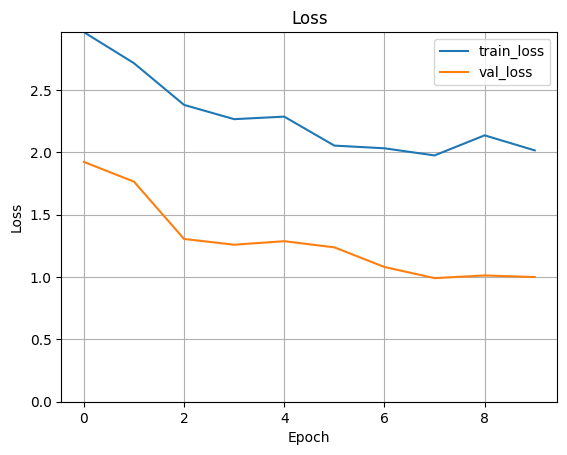

In [43]:
plot_loss(history)

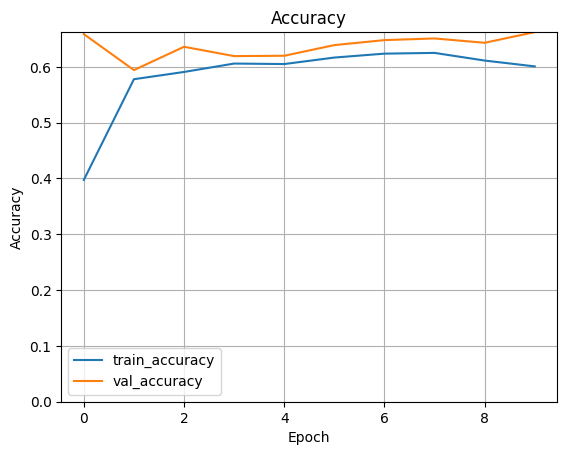

In [44]:
plot_accuracy(history)

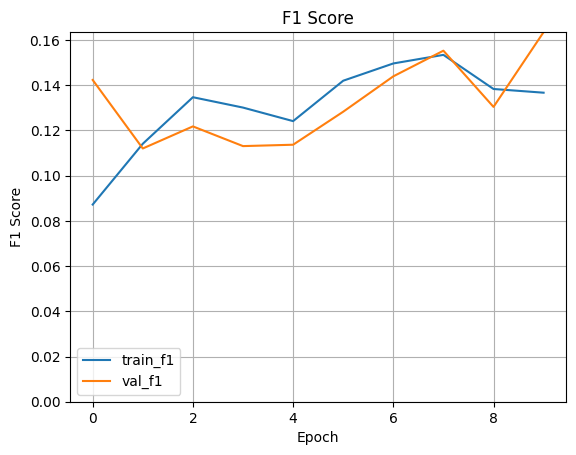

In [45]:
plot_f1(history)

In [46]:
y_pred2 = cnn_model1.predict([images_mini_v, street_mini_v])
y_pred2

53/53 [==============================] - 35s 664ms/step


array([[8.4042931e-01, 6.2710606e-03, 4.1593842e-02, ..., 4.3688905e-03,
        5.2263397e-03, 6.3073295e-03],
       [1.0282212e-01, 1.2869467e-01, 3.3102316e-01, ..., 1.3523904e-02,
        3.4616187e-02, 1.6456587e-02],
       [2.7261662e-01, 4.2320564e-02, 2.5264710e-01, ..., 6.5361173e-03,
        9.4748633e-03, 1.1408749e-02],
       ...,
       [1.2907821e-01, 9.1812566e-02, 2.2684860e-01, ..., 1.3754020e-02,
        1.5593061e-02, 2.1886371e-02],
       [3.4393847e-01, 2.1170241e-04, 5.0348282e-01, ..., 1.4338286e-05,
        2.2876381e-03, 1.5145498e-04],
       [7.1562892e-01, 6.7620729e-03, 1.5429664e-01, ..., 1.6331602e-03,
        4.6534678e-03, 4.4735875e-03]], dtype=float32)

In [47]:
pred_values2 = []
for i in y_pred2: 
    input_list = i
    max_value = max(input_list)
    index = [index for index, item in enumerate(input_list) if item == max_value]
    pred_values2.append(index[0])
pred_values2[0:5]

[0, 2, 0, 1, 2]

In [50]:
y_true = list(y_val)
y_true[0:5]

[0, 0, 0, 0, 0]

In [53]:
len(y_true)
len(pred_values2)

1676

In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, pred_values2)
ind = max(len(np.unique(y_true)), len(np.unique(pred_values2)))
df_cm = pd.DataFrame(cm, index = [i for i in range(ind+1)],
                  columns = [i for i in range(ind+1)])
df_cm
#plt.figure(figsize = (10,7))
#sn.heatmap(df_cm, annot=True)

,0,1,2,3,4,5,6,7,8,9
0,985,21,255,37,24,0,22,0,0,3
1,1,15,1,3,3,0,3,0,0,0
2,40,36,99,24,18,0,13,0,1,2
3,2,23,11,10,2,0,3,0,2,0
4,0,2,0,0,0,0,0,0,1,1
5,0,0,0,0,0,0,0,0,1,0
6,0,5,0,0,1,0,0,0,0,2
7,0,2,0,0,0,0,0,0,1,0
8,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,0,0,0


**Model 2.4.2: Class Weights Corrected 2**

In [56]:
check = pd.DataFrame({'bins': y_train, 'ones': np.ones(len(y_train))}, columns=['bins', 'ones'])
pivot = check.pivot_table(index=['bins'], values=['ones'], aggfunc=len)
print(pivot)

      ones
bins      
0     5297
1      108
2      968
3      230
4       22
5        4
6       53
7       11
8        3
9        1
10       3


In [57]:
from sklearn.utils import class_weight 
class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.11498790052688486,
 1: 5.63973063973064,
 2: 0.6292261457550714,
 3: 2.6482213438735176,
 4: 27.68595041322314,
 5: 152.27272727272728,
 6: 11.492281303602057,
 7: 55.37190082644628,
 8: 203.03030303030303,
 9: 609.0909090909091,
 10: 203.03030303030303}

In [58]:
# From previous experiments, adding layers and using ResNet-18 yielded best results 

# x: Satellite Images, 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'Collisions_Historical', Road type (one hot), Zipcode (ont hot)
# y: Future collision bin

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,39), name='Input_Street') 
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(39, (2,2), activation="relu")(input1) # layers = street data dimension
    pooling = tf.keras.layers.MaxPooling2D((53, 93), strides=1)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    output = tf.keras.layers.Dense(units=11, activation='softmax', name='output')(resnet) # units = number of classes
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model1 = create_cnn_model()

cnn_model1.summary()

f1 = tfa.metrics.F1Score(
    num_classes = 11,
    average = 'macro',
    threshold = None,
    name = 'f1',
    )

cnn_model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = ['accuracy', keras.metrics.Precision(), f1])

# calculated in previous block 
# class_weight = {0: 1,
#                 1: 10,
#                 2: 10,
#                 3: 10,
#                 4: 10,
#                 5: 10,
#                 6: 10,
#                 7: 10,
#                 8: 10,
#                 9: 10,
#                 10: 10,
#                 # 11: 10,
#                }

y_t = tf.keras.utils.to_categorical(y_train, num_classes=11)

y_v = tf.keras.utils.to_categorical(y_val, num_classes=11)

#cnn_model1.load_weights(initial_weights) # initial weights from first or baseline model to make it comparable
#cnn_model1.layers[-1].bias.assign([0,0,0,0,0,0,0,0,0,0,0]) # no bias, makes it more comparable to baseline model

history = cnn_model1.fit(
    [images_mini, street_mini],
    y_t,
    epochs=10,
    # Suppress logging.
     verbose=1,
    validation_data=([images_mini_v, street_mini_v], y_v),
    # Calculate validation results on 20% of the training data.
    #validation_split = 0.2,
    class_weight = class_weights
    )

/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 147, 187, 39  663         ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 95, 95, 39)  0           ['conv2d_1[0][0]']               
                                                                                            

 layer2.0.relu1 (ReLU)          (None, 12, 12, 128)  0           ['layer2.0.bn1[0][0]']           
                                                                                                  
 layer2.0.conv2_pad (ZeroPaddin  (None, 14, 14, 128)  0          ['layer2.0.relu1[0][0]']         
 g2D)                                                                                             
                                                                                                  
 layer2.0.downsample.0 (Conv2D)  (None, 12, 12, 128)  8192       ['layer1.1.relu2[0][0]']         
                                                                                                  
 layer2.0.conv2 (Conv2D)        (None, 12, 12, 128)  147456      ['layer2.0.conv2_pad[0][0]']     
                                                                                                  
 layer2.0.downsample.1 (BatchNo  (None, 12, 12, 128)  512        ['layer2.0.downsample.0[0][0]']  
 rmalizati

                                                                                                  
 layer3.1.conv2 (Conv2D)        (None, 6, 6, 256)    589824      ['layer3.1.conv2_pad[0][0]']     
                                                                                                  
 layer3.1.bn2 (BatchNormalizati  (None, 6, 6, 256)   1024        ['layer3.1.conv2[0][0]']         
 on)                                                                                              
                                                                                                  
 layer3.1.add (Add)             (None, 6, 6, 256)    0           ['layer3.0.relu2[0][0]',         
                                                                  'layer3.1.bn2[0][0]']           
                                                                                                  
 layer3.1.relu2 (ReLU)          (None, 6, 6, 256)    0           ['layer3.1.add[0][0]']           
          

/home/ubuntu/capstone/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/10
210/210 [==============================] - 330s 2s/step - loss: 3.7805 - accuracy: 0.5552 - precision_1: 0.3612 - f1: 0.1040 - val_loss: 1.1248 - val_accuracy: 0.7047 - val_precision_1: 0.8252 - val_f1: 0.1348
Epoch 2/10
210/210 [==============================] - 317s 2s/step - loss: 2.4214 - accuracy: 0.5875 - precision_1: 0.7394 - f1: 0.1286 - val_loss: 0.9966 - val_accuracy: 0.6891 - val_precision_1: 0.8767 - val_f1: 0.1253
Epoch 3/10
210/210 [==============================] - 316s 2s/step - loss: 2.3464 - accuracy: 0.6185 - precision_1: 0.8181 - f1: 0.1251 - val_loss: 1.1759 - val_accuracy: 0.6217 - val_precision_1: 0.8411 - val_f1: 0.1197
Epoch 4/10
210/210 [==============================] - 316s 2s/step - loss: 2.2332 - accuracy: 0.6227 - precision_1: 0.8385 - f1: 0.1418 - val_loss: 1.3243 - val_accuracy: 0.6002 - val_precision_1: 0.8376 - val_f1: 0.1022
Epoch 5/10
210/210 [==============================] - 317s 2s/step - loss: 2.2268 - accuracy: 0.6210 - precision_1: 

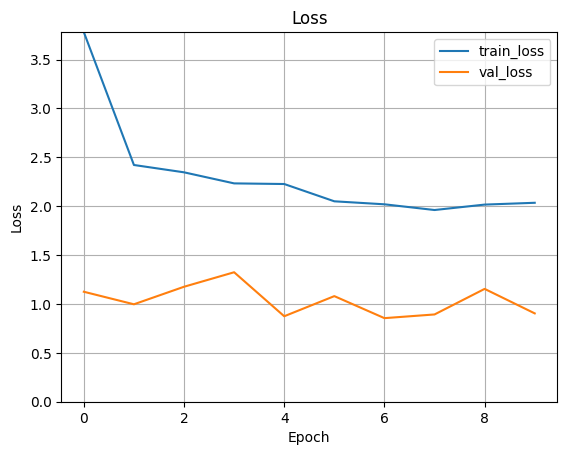

In [59]:
plot_loss(history)

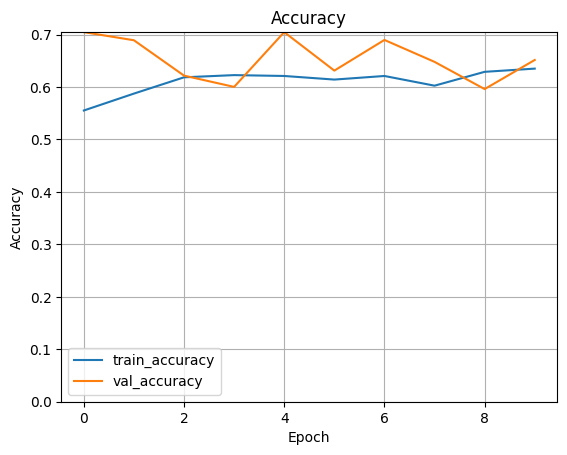

In [60]:
plot_accuracy(history)

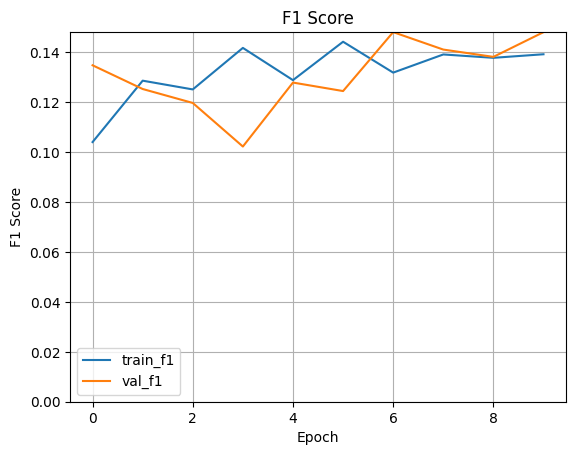

In [61]:
plot_f1(history)

In [62]:
y_pred2 = cnn_model1.predict([images_mini_v, street_mini_v])
y_pred2

53/53 [==============================] - 35s 664ms/step


array([[8.4351557e-01, 1.3890082e-02, 8.8312626e-02, ..., 3.1785964e-04,
        4.1771185e-05, 2.2114959e-04],
       [2.1920198e-01, 1.6417079e-02, 6.4112061e-01, ..., 4.0891688e-04,
        1.0806396e-04, 2.4862925e-04],
       [4.3744430e-01, 6.8277560e-02, 2.4295485e-01, ..., 1.5263909e-03,
        9.9272249e-05, 6.0967193e-04],
       ...,
       [1.5986557e-01, 1.3955647e-01, 3.1031546e-01, ..., 4.4393549e-03,
        4.0443652e-04, 2.2287422e-03],
       [2.9149893e-01, 5.8067448e-02, 4.4846392e-01, ..., 1.0481788e-03,
        1.6610001e-04, 9.0669631e-04],
       [5.7356513e-01, 1.9652371e-03, 4.0104431e-01, ..., 5.1213137e-04,
        1.5561227e-04, 5.1583309e-04]], dtype=float32)

In [63]:
pred_values2 = []
for i in y_pred2: 
    input_list = i
    max_value = max(input_list)
    index = [index for index, item in enumerate(input_list) if item == max_value]
    pred_values2.append(index[0])
pred_values2[0:5]

[0, 2, 0, 3, 2]

In [64]:
y_true = list(y_val)
y_true[0:5]

[0, 0, 0, 0, 0]

<Axes: title={'center': 'Confusion Matrix'}>

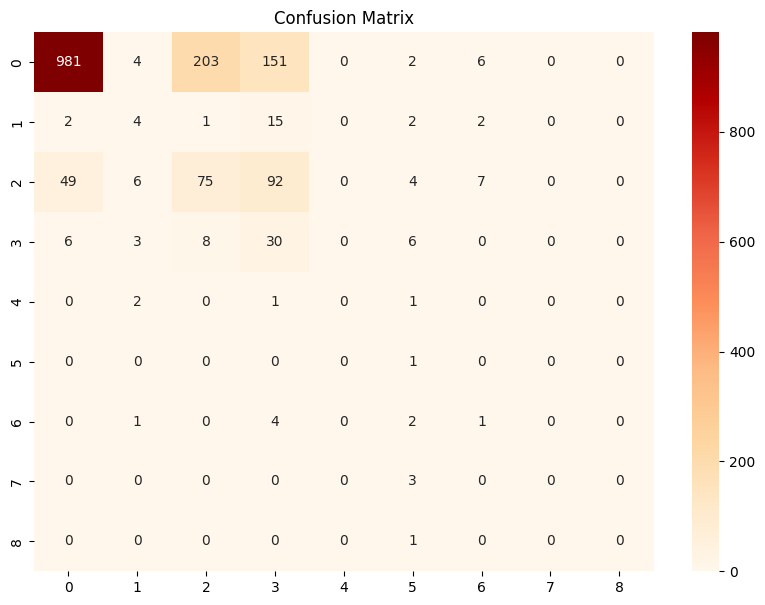

In [71]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, pred_values2)
ind = max(len(np.unique(y_true)), len(np.unique(pred_values2)))
df_cm = pd.DataFrame(cm, index = [i for i in range(ind)],
                  columns = [i for i in range(ind)])
df_cm
plt.figure(figsize = (10,7))
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
sn.heatmap(df_cm, annot=True, fmt='.3g',cmap="OrRd")

**Model 2.4.3: Initial Bias and Class Weights Corrected**

In [ ]:
# initial_bias = []
# for i in range(len(pivot['ones'])):
#     b = np.log(pivot['ones'][i] / (sum(pivot['ones'][:i]) + sum(pivot['ones'][i + 1:])))
#     initial_bias.append(b)
# initial_bias

In [ ]:
# from sklearn.utils import class_weight 
# class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
# class_weights = dict(enumerate(class_weights))
# class_weights

In [ ]:
# # From previous experiments, adding layers and using ResNet-18 yielded best results 

# # x: Satellite Images, 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'Collisions_Historical', Road type (one hot), Zipcode (ont hot)
# # y: Future collision bin

# # ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# # THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# # REFERENCE THE DIAGRAM ON THE PAPER

# def create_cnn_model3(output_bias = None):

#     # INPUT LAYERS
#     input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
#     input2 = tf.keras.layers.Input(shape=(1,1,39), name='Input_Street') 
    
#     #CNN FOR IMAGE PROCESSING
#     cnn = tf.keras.layers.Conv2D(39, (2,2), activation="relu")(input1) # layers = street data dimension
#     pooling = tf.keras.layers.MaxPooling2D((2, 2), strides=1)(cnn)
#     images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
#     #ADDING STREET DATA
#     #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
#     combined = tf.keras.layers.Add()([images.output, input2])
    
#     # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
#     resnet = resnet18(combined)
    
#     if output_bias is not None:
#         # initial bias added
#         output_bias = tf.keras.initializers.Constant(output_bias)    
#         output = tf.keras.layers.Dense(units=11, activation='softmax', name='output', bias_initializer=output_bias)(resnet) # units = number of classes
#     else: 
#         output = tf.keras.layers.Dense(units=11, activation='softmax', name='output')(resnet) # units = number of classes
        
#     #instantiation layer 
#     cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
#     return cnn_model

# # initial bias added
# cnn_model3 = create_cnn_model3(output_bias = initial_bias)

# cnn_model3.summary()

# f1 = tfa.metrics.F1Score(
#     num_classes = 11,
#     average = 'macro',
#     threshold = None,
#     name = 'f1',
#     )

# cnn_model3.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
#     loss='categorical_crossentropy',
#     metrics = ['accuracy', f1])

# # class_weight = {0: 1,
# #                 1: 10,
# #                 2: 10,
# #                 3: 10,
# #                 4: 10,
# #                 5: 10,
# #                 6: 10,
# #                 7: 10,
# #                 8: 10,
# #                 9: 10,
# #                 10: 10,
# #                 # 11: 10,
# #                }

# y_t = tf.keras.utils.to_categorical(y_train, num_classes=11)

# y_v = tf.keras.utils.to_categorical(y_val, num_classes=11)

# #cnn_model1.load_weights(initial_weights) # initial weights from first model to make it comparable

# history = cnn_model3.fit(
#     [images_mini, street_mini],
#     y_t,
#     epochs=10,
#     # Suppress logging.
#      verbose=1,
#     validation_data=([images_mini_v, street_mini_v], y_v),
#     # Calculate validation results on 20% of the training data.
#     #validation_split = 0.2,
#     class_weight = class_weights
#     )

In [ ]:
# plot_loss(history)

In [ ]:
# plot_accuracy(history)

In [ ]:
# plot_f1(history)

In [ ]:
# y_pred = cnn_model3.predict([images_mini_v, street_mini_v])
# y_pred

In [ ]:
# pred_values3 = []
# for i in y_pred: 
#     input_list = i
#     max_value = max(input_list)
#     index = [index for index, item in enumerate(input_list) if item == max_value]
#     pred_values3.append(index[0])
# pred_values3[0:5]

In [ ]:
# y_true = list(y_val)
# y_true[0:5]

In [ ]:
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_true, pred_values3)
# ind = max(len(np.unique(y_true)), len(np.unique(pred_values3)))
# df_cm = pd.DataFrame(cm, index = [i for i in range(ind)],
#                   columns = [i for i in range(ind)])
# df_cm
# #plt.figure(figsize = (10,7))
# #sn.heatmap(df_cm, annot=True)